In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import signal
from copy import copy
from tqdm import tqdm

from moku.nn import LinnModel, save_linn

# Data Generation

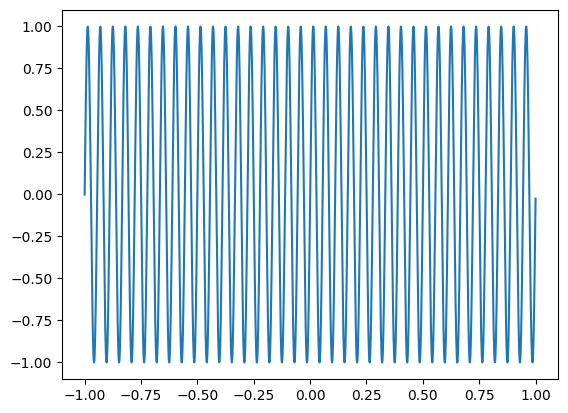

In [2]:
X = np.arange(0, np.pi*8, 0.01)
X_norm = np.linspace(-1, 1, len(X))

def gen_function(input_array):
    func_type = random.randint(1,3)
    num_cycles = random.randint(1,20)
    
    if func_type == 1:
        ### generate sine wave ###
        output_array = np.sin(num_cycles*input_array)
        answer = np.array((1,-1,-1))

    elif func_type == 2:
        ### generate square wave
        output_array = signal.square(num_cycles*input_array)
        answer = np.array((-1,1,-1))

    else:
        ### generate sawtooth wave
        output_array = signal.sawtooth(num_cycles*input_array)
        answer = np.array((-1,-1,1))

        
    return output_array, answer


Y_norm, Y_answer = gen_function(X)
plt.plot(X_norm, Y_norm)
plt.show()

In [3]:
# generate some training data
dr = 1000

training_data = np.zeros((dr, X_norm.size))

training_answers = np.zeros((dr, 3))

print(training_data.shape)
print(training_answers.shape)

for idx in tqdm(range(dr)):
    Y_norm, Y_answer = gen_function(X)
    training_data[idx, :] = Y_norm
    training_answers[idx,:] = Y_answer

(1000, 2514)
(1000, 3)


100%|██████████| 1000/1000 [00:00<00:00, 17906.32it/s]


100%|██████████| 1000/1000 [00:00<00:00, 31139.27it/s]

(78000, 32)
(78000, 3)
[ 1. -1. -1.]


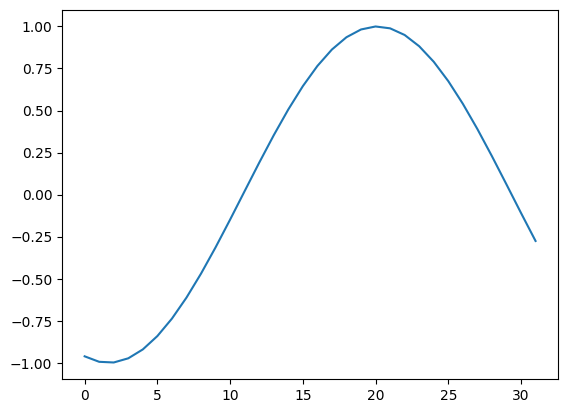

In [4]:
# waveform batch size
bs = 32

N = X_norm.size
training_batched = []
answers_batched = []
for j in tqdm(range(training_data.shape[0])):
    for idx in range(0, N, bs):
        if idx+bs < N:
            training_batched.append(training_data[j, idx:idx+bs])
            answers_batched.append(training_answers[j])

training_batched = np.array(training_batched)
answers_batched = np.array(answers_batched)
print(training_batched.shape)
print(answers_batched.shape)

plt.plot(training_batched[20000,:])
print(answers_batched[20000,:])

# Model Definitions

In [7]:
# create the quantised model object and set the training data
quant_mod = LinnModel()
quant_mod.set_training_data(training_inputs=training_batched, training_outputs=answers_batched)

In [10]:
# model definition for an autoencoder
model_definition = [(32, 'tanh'), (64, 'tanh'), (32, 'tanh'), (3, 'linear')]
# build the model
quant_mod.construct_model(model_definition, show_summary=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_3             │ (None, 32)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_4             │ (None, 64)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_5             │ (None, 32)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_6             │ (None, 3)              │             0 │
│ (OutputClipLayer)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,347 (20.89 KB)

 Trainable params: 5,347 (20.89 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = quant_mod.fit_model(epochs=1000, es_config={'pateience': 20}, validation_split=0.1)

Value for monitor missing. Using default:val_loss.
Value for patience missing. Using default:5.
Value for restore missing. Using default:False.


Epoch 1/1000
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - loss: 0.0328 - val_loss: 0.0241
Epoch 2/1000
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - loss: 0.0320 - val_loss: 0.0116
Epoch 3/1000
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - loss: 0.0311 - val_loss: 0.0153
Epoch 4/1000
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step - loss: 0.0296 - val_loss: 0.0224
Epoch 5/1000
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step - loss: 0.0326 - val_loss: 0.0166
Epoch 6/1000
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step - loss: 0.0278 - val_loss: 0.0073
Epoch 7/1000
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 0.0331 - val_loss: 0.0313
Epoch 8/1000
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step - loss: 0.0274 - val_loss: 0.0177
Epoch 9/1000
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step - loss: 0.0240 - val_loss: 0.0070
Epoch 10/1000
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 0.0281 - val_loss: 0.0200
Epoch 11/1000
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - loss: 0.0283 - val

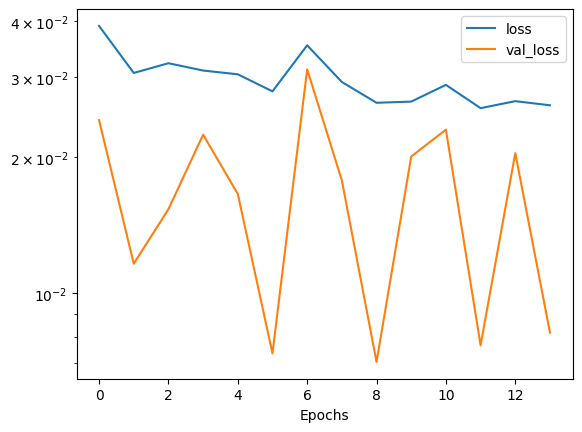

In [16]:
# plot the losses
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

In [17]:
Y_norm, Y_answer = gen_function(X)

preds = quant_mod.predict(Y_norm[0:32].reshape(1,-1), scale=False, unscale_output=False)
print(Y_answer)
print(preds[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[ 1 -1 -1]
[ 1. -1. -1.]


In [18]:
quant_mod.model.save('siginal_id.keras')
save_linn(quant_mod.model, input_channels=1, output_channels=3, file_name='signa_id.linn')

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 172 cycles
